Ansuman Das
17PH20006

In [1]:
#Importing libraries
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.optim as optim

In [2]:
def data(Batch):
    #Loading Datasets
    do_transform=transforms.Compose([transforms.ToTensor()])
    Batch_size=Batch
#Training data
    trainset=datasets.MNIST(root="./MNIST",train=True,download=True,transform=do_transform)
    train_dataloader=torch.utils.data.DataLoader(trainset,batch_size=Batch_size,shuffle=True,num_workers=4,)
#Test Data
    testset=datasets.MNIST(root="./MNIST",train=False,download=True,transform=do_transform)
    test_dataloader=torch.utils.data.DataLoader(testset,batch_size=Batch_size,shuffle=True,num_workers=4,)
#size of trining and test set
#    print("Number of training example is ;"+str(len(train_dataloader.dataset)))
#    print("Number of test example is ;"+str(len(test_dataloader.dataset)))
    return train_dataloader,test_dataloader

In [3]:
class MyLeNet(nn.Module):
    def __init__(self):      
        super(MyLeNet, self).__init__()     
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)     #output_size=batch_size*1*24*24
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)      #output_size=batch_size*1*12*12 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)           #output_size=batch_size*16*8*8
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)         #output_size=batch_size*16*4*4
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [4]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated(device=None)
torch.cuda.reset_max_memory_cached(device=None)

In [5]:
gpu=torch.cuda.is_available()
net=MyLeNet()
print(net)
if gpu:
    print("Cuda is available")
    net=net.cuda()

MyLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Cuda is available


In [6]:
#Optimizing using Adam

In [7]:
def Mynet_Adam(train_dataloader,Learning_rate,epochs,Batch_size):
    
    net=MyLeNet()
    net=net.cuda()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated(device=None)
    torch.cuda.reset_max_memory_cached(device=None)
    
    criteria=nn.CrossEntropyLoss()  #nn.BCELoss()  may be used
    learning_rate=Learning_rate
    num_epochs=epochs
    model_loss=[]
    model_acc=[]
#    train_dataloader,test_dataloader=data(Batch_size)

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        temp_loss=0.0
        temp_acc=0.0
        for i,data in enumerate(train_dataloader):
            inputs,labels=data
            if gpu:
                inputs,labels=inputs.cuda(),labels.cuda()          
            optimizer.zero_grad()
            outputs = net(inputs)
#       print(inputs.shape)
#       print(outputs.shape)
            preds=torch.argmax(outputs,dim=1)
            loss=criteria(outputs,labels)        
            temp_loss+=loss.item()    #saving loss values in the loop
            temp_acc+=torch.sum(preds==labels)
            loss.backward()
    
            optimizer.step()   #optimisation step
    
    
   
    
    
        
        epoch_loss = temp_loss/(i+1)   #Total loss for one epoch
        epoch_acc = temp_acc.item()/60000.0
    
    
         
        model_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        model_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
 #       print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))              
    return net,epoch_loss,epoch_acc
    


In [8]:
def prediction(net,test_dataloader):
    correct_pred = 0
    for data in test_dataloader:
        inputs,labels = data
        if gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
        output = net(inputs) 
    # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)

    test_accuracy = correct_pred.item()/10000.0
    return test_accuracy

In [9]:
#control 
epoch=10

In [10]:
Learning_rates=[1,0.6,0.3,0.1,0.06,0.03,0.010,0.006,0.003,0.001]
#Learning_rates=[0.3,0.1,0.06]
train_loss=[]
train_acc=[]
test_accuracy=[]
for i in Learning_rates:
    train_dataloader,test_dataloader=data(256)
    net,training_loss,training_acc=Mynet_Adam(train_dataloader,i,epochs=epoch,Batch_size=256)
    print('Learning_rate: {:.4f} |,Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(i,training_loss,training_acc*100))
    train_loss.append(training_loss)
    train_acc.append(training_acc)
    test_acc=prediction(net,test_dataloader)
    test_accuracy.append(test_acc)
    print('Testing accuracy Using ADAM: {:.4f}'.format(test_acc*100))
    

Learning_rate: 1.0000 |,Training loss: 2.3360 | Training Accuracy: 9.9500
Testing accuracy Using ADAM: 9.8000
Learning_rate: 0.6000 |,Training loss: 2.3232 | Training Accuracy: 10.1567
Testing accuracy Using ADAM: 11.3500
Learning_rate: 0.3000 |,Training loss: 2.3121 | Training Accuracy: 10.2133
Testing accuracy Using ADAM: 10.3200
Learning_rate: 0.1000 |,Training loss: 2.3057 | Training Accuracy: 10.6383
Testing accuracy Using ADAM: 11.3500
Learning_rate: 0.0600 |,Training loss: 2.3039 | Training Accuracy: 10.6650
Testing accuracy Using ADAM: 11.3500
Learning_rate: 0.0300 |,Training loss: 0.1247 | Training Accuracy: 97.0517
Testing accuracy Using ADAM: 96.5300
Learning_rate: 0.0100 |,Training loss: 0.0332 | Training Accuracy: 98.9783
Testing accuracy Using ADAM: 98.7900
Learning_rate: 0.0060 |,Training loss: 0.0193 | Training Accuracy: 99.3650
Testing accuracy Using ADAM: 98.9600
Learning_rate: 0.0030 |,Training loss: 0.0226 | Training Accuracy: 99.2733
Testing accuracy Using ADAM: 98

Text(0, 0.5, 'Training Accuracy')

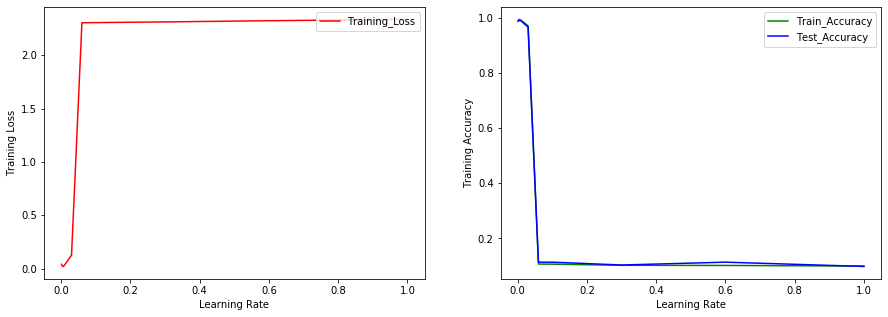

In [11]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(Learning_rates,train_loss,'r-',label='Training_Loss') 
plt.legend(loc='upper right')
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.subplot(122)
plt.plot(Learning_rates,train_acc,'g-',label='Train_Accuracy') 
plt.plot(Learning_rates,test_accuracy,'b-',label='Test_Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')

In [12]:
Batches=[16,32,64,128,256,512,1024]
#Batches=[64,128,256]
train_loss=[]
train_acc=[]
test_accuracy=[]
for i in Batches:
    train_dataloader,test_dataloader=data(i)
    net,training_loss,training_acc=Mynet_Adam(train_dataloader,0.03,Batch_size=i,epochs=epoch)
    print('Batches: {:.4f} |,Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(i,training_loss,training_acc*100))
    train_loss.append(training_loss)
    train_acc.append(training_acc)
    test_acc=prediction(net,test_dataloader)
    test_accuracy.append(test_acc)
    print('Testing accuracy Using ADAM: {:.4f}'.format(test_acc*100))


Batches: 16.0000 |,Training loss: 2.3067 | Training Accuracy: 10.4633
Testing accuracy Using ADAM: 10.3200
Batches: 32.0000 |,Training loss: 0.5464 | Training Accuracy: 84.9267
Testing accuracy Using ADAM: 83.9700
Batches: 64.0000 |,Training loss: 2.3040 | Training Accuracy: 10.7083
Testing accuracy Using ADAM: 9.8000
Batches: 128.0000 |,Training loss: 0.1572 | Training Accuracy: 96.5950
Testing accuracy Using ADAM: 96.3200
Batches: 256.0000 |,Training loss: 0.2840 | Training Accuracy: 90.8083
Testing accuracy Using ADAM: 88.8700
Batches: 512.0000 |,Training loss: 0.0811 | Training Accuracy: 97.6500
Testing accuracy Using ADAM: 96.3500
Batches: 1024.0000 |,Training loss: 0.0485 | Training Accuracy: 98.4383
Testing accuracy Using ADAM: 97.6500


Text(0, 0.5, 'Training Accuracy')

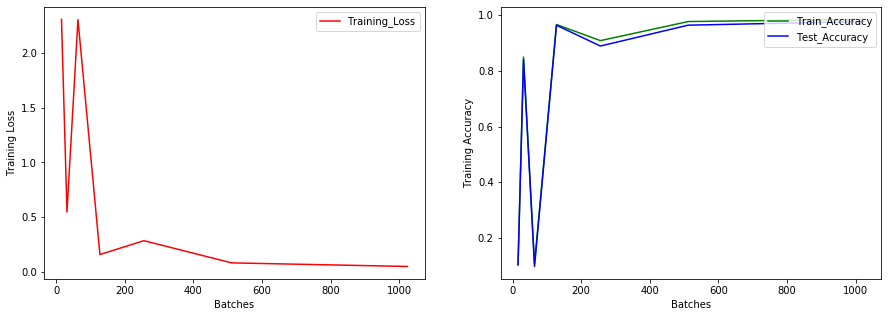

In [13]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(Batches,train_loss,'r-',label='Training_Loss') 
plt.legend(loc='upper right')
plt.xlabel('Batches')
plt.ylabel('Training Loss')
plt.subplot(122)
plt.plot(Batches,train_acc,'g-',label='Train_Accuracy') 
plt.plot(Batches,test_accuracy,'b-',label='Test_Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Batches')
plt.ylabel('Training Accuracy')